In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import uns
import pandas as pd
from skimage.morphology import convex_hull_image
folder = '/home/chrisv/code/fcn_train_log/BatchOf10'
filepattern = 'predictions_*'
files = glob.glob(os.path.join(folder, filepattern))

In [2]:
from skimage.morphology import convex_hull_image

In [142]:
tr = pd.read_msgpack('trainvalidate.bin')


In [99]:
def ndice(pred_batch,label_batch,sh=(416,576)):
      n_batch = pred_batch.shape[0]
      preds = pred_batch.reshape([n_batch,sh[0],sh[1]])
      labels = label_batch.reshape([n_batch,sh[0],sh[1]])
      denoms = np.sum(preds,axis=(1,2)) + np.sum(labels,axis=(1,2))
      cap = np.logical_and(preds, labels)
      numerators = 2*np.sum(cap, axis=(1,2))
      zero_denoms = np.where(denoms ==0)
      nonzero_denoms = np.where (denoms !=0)
      result = np.empty(denoms.shape)
      result[zero_denoms] = 1
      result[nonzero_denoms] = np.divide(numerators[nonzero_denoms],denoms[nonzero_denoms])
      return result

def onedice(pred, truth, sh=(416,576)):
    return ndice(np.expand_dims(pred, axis=0), np.expand_dims(truth, axis=0), sh=sh)[0]

In [100]:
idxpred = 0
idxmask = 1

#for f in files:
#    print(f, ": ", np.load(f).shape)

In [101]:
strange_data = np.concatenate([np.load(f) for f in files], axis=0)

In [102]:
data = np.reshape(np.transpose(strange_data,(0,2,1,3,4)), (-1,2,416,576))

In [19]:
# Pixel count cutoff
# convex hull or shape normalization
# softmax output (not predictions)


In [238]:
cutoff = np.linspace(0,1,num=20)

score = [np.mean(ndice(data[:,idxpred,:,:]>c, 1-data[:,idxmask,:,:])) for c in cutoff]


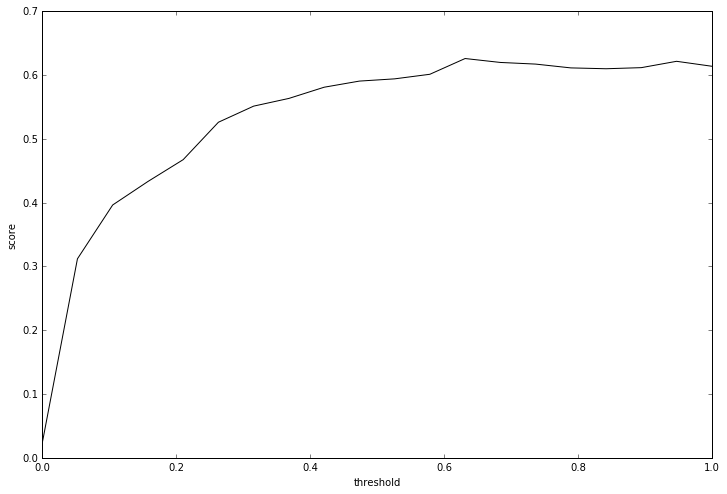

In [240]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(cutoff, score, '-k')
ax.set_ylabel('score')
ax.set_xlabel('threshold')

Why so many zero scores?

In [34]:
cutoff=0.6

maskpix = np.array([np.sum(m) for m in 1-data[:,idxmask,:,:]] )
predpix = np.array([np.sum(p) for p in data[:,idxpred,:,:]>0.5])


rawscores = ndice(data[:,idxpred,:,:]>cutoff, 1-data[:,idxmask,:,:])
print('Raw score: {}'.format(np.mean(rawscores)))
subset = data[predpix<1000,idxpred,:,:]>cutoff
minsizescores = copy(rawscores)
core[predpix<1000] = ndice(subset, np.zeros_like(subset))

print('Filter small masks: {}'.format(np.mean(score)))

Raw score: 0.6119035647281671
Filter small masks: 0.7094711576085821


In [35]:
indices = np.argwhere(np.logical_and(score>0.1, score<0.5)).flatten()
print(indices[:10])
batch = uns.batch(tr[tr['validate']].iloc[indices[:10]])

[28 29 34 36 38 47 53 55 61 67]


(0, 1000)

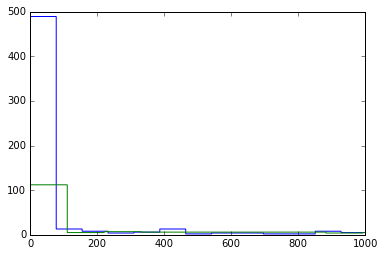

In [39]:
plt.hist(predpix[maskpix<0.1], bins=100, histtype='step')
plt.hist(predpix[maskpix>0.1], bins=100, histtype='step')
plt.xlim([0,1000])

In [86]:
def plot_pred_prob(idx, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))    
    ax.imshow(data[idx,idxpred,:,:], alpha=1, cmap=plt.cm.plasma)
    ax.imshow(data[idx,idxmask,:,:], alpha=0.5, cmap=plt.cm.gray)
    ax.set_title(score[idx])
    return ax

def plot_pred_mask(idx, ax=None, cutoff=0.6, msk=None, scr=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))    
    ax.imshow(data[idx,idxpred,:,:], alpha=1, cmap=plt.cm.plasma)
    ax.imshow(data[idx,idxpred,:,:]>cutoff, alpha=0.5, cmap=plt.cm.gray_r)
    if msk is True:
        msk = uns.mask(255*data[idx,idxmask,:,:])
    if msk is not None:
        msk.plot_contour(ax=ax, c='r', lw=2.0)
    if scr is None:
        '{:2f}'.format(score[idx])
    else:
        title = '{:2f} -> {:2f}'.format(score[idx], scr)
        
    ax.set_title(title)
    return ax

def convex_mask(idx, cutoff=0.6, unsmask=False):
    convex =  convex_hull_image(data[idx,idxpred,:,:]>cutoff)
    truth = 1-data[idx:idxmask,:,:]
    print(convex.shape, truth.shape)
    
    score = onedice(convex, truth)
    if unsmask:
        return score, uns.mask(convex*255)
    else:
        return score



In [96]:
for idx in indices:
    print(onedice(data[idx,idxpred,:,:]>0.6,1-data[idx,idxmask,:,:]))

1.0
0.0
0.0
0.0
0.704056512897
0.762355415352
1.0
0.0
1.0
1.0


## evaluate how a convex hull would help the scoring:



In [95]:
indices = np.random.random_integers(0, 1000, 10)
for idx in indices:
    score, msk = convex_mask(idx, unsmask=True)
    plot_pred_mask(idx, msk=msk, scr=score)

/home/chrisv/.conda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 1000 + 1) instead
  if __name__ == '__main__':
/home/chrisv/.conda/envs/tensorflow/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


ValueError: No points given

Set any predictions with less than X pixels to zero

0 : 28 subject        2
img           41
hasmask    False
Name: 160, dtype: object


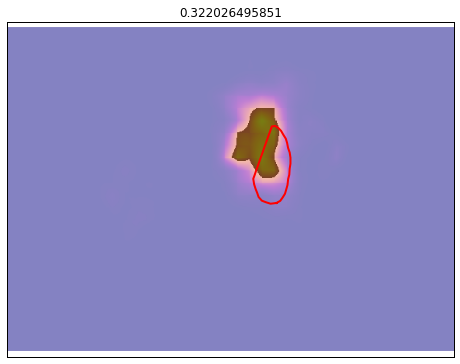

1 : 29 subject        2
img           45
hasmask    False
Name: 164, dtype: object


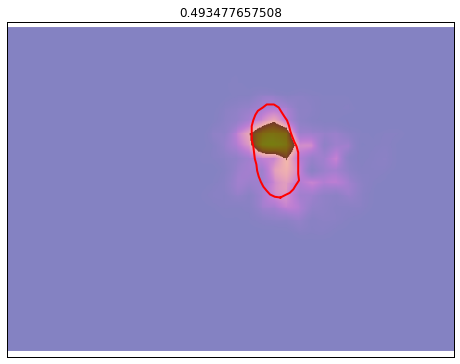

2 : 34 subject        2
img           66
hasmask    False
Name: 185, dtype: object


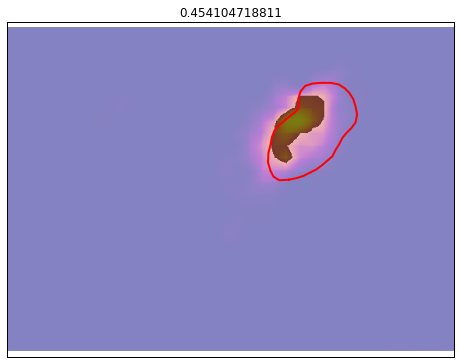

3 : 36 subject        2
img           76
hasmask    False
Name: 195, dtype: object


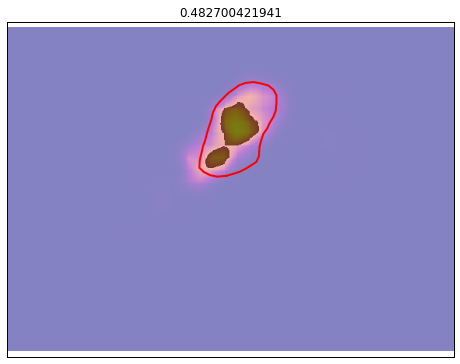

4 : 38 subject        2
img           89
hasmask    False
Name: 208, dtype: object


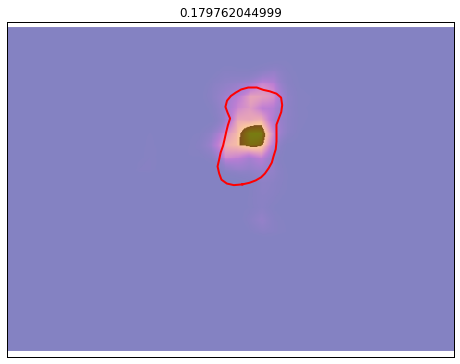

5 : 47 subject       3
img           6
hasmask    True
Name: 245, dtype: object


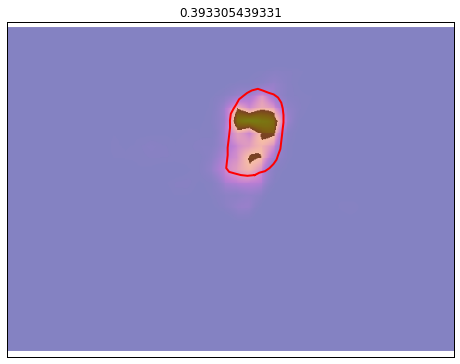

6 : 53 subject        3
img           31
hasmask    False
Name: 270, dtype: object


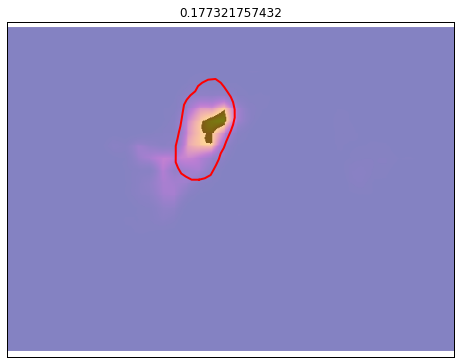

7 : 55 subject       3
img          35
hasmask    True
Name: 274, dtype: object


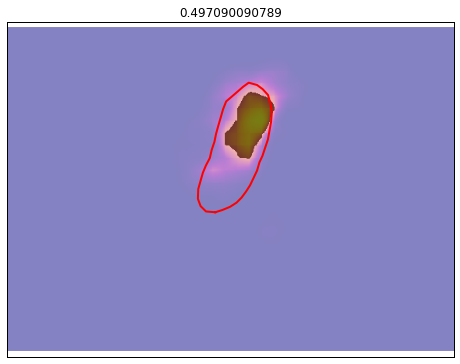

8 : 61 subject       3
img          56
hasmask    True
Name: 295, dtype: object


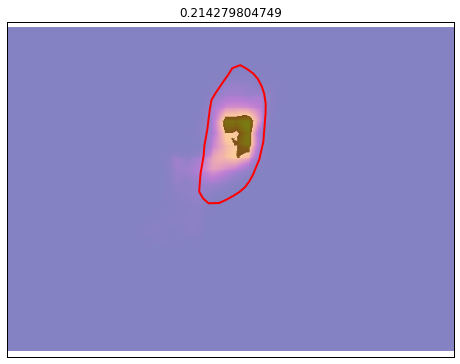

9 : 67 subject       3
img          66
hasmask    True
Name: 305, dtype: object


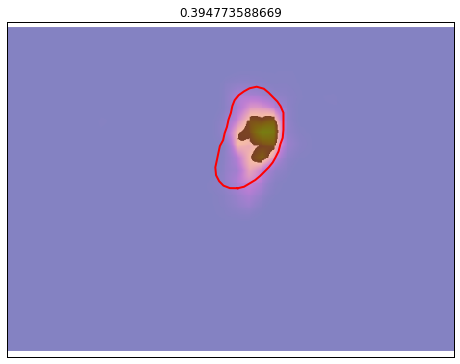

10 : 70 subject        3
img           74
hasmask    False
Name: 313, dtype: object


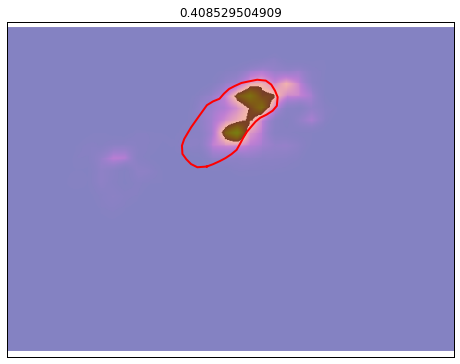

11 : 72 subject        3
img           86
hasmask    False
Name: 325, dtype: object


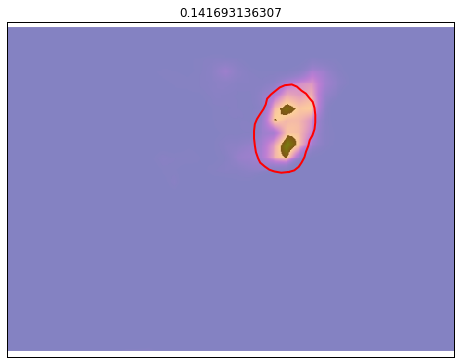

12 : 73 subject        3
img           90
hasmask    False
Name: 329, dtype: object


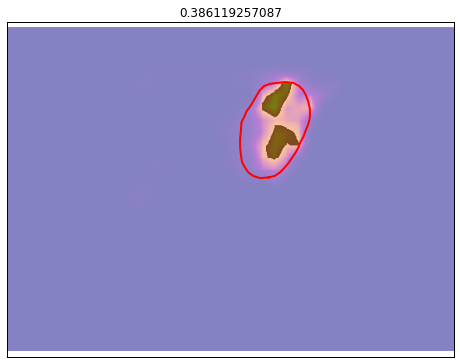

13 : 76 subject       3
img         113
hasmask    True
Name: 352, dtype: object


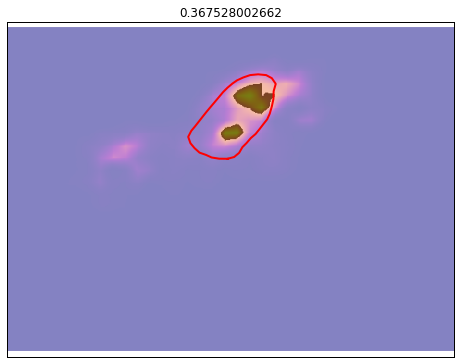

14 : 79 subject        4
img           19
hasmask    False
Name: 377, dtype: object


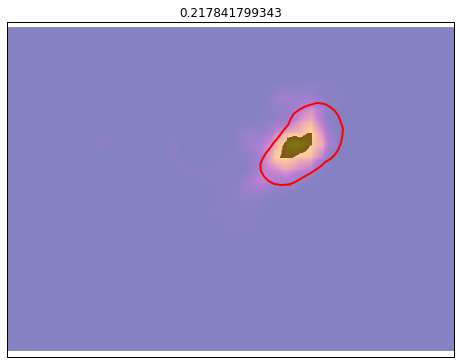

15 : 86 subject        4
img           48
hasmask    False
Name: 406, dtype: object


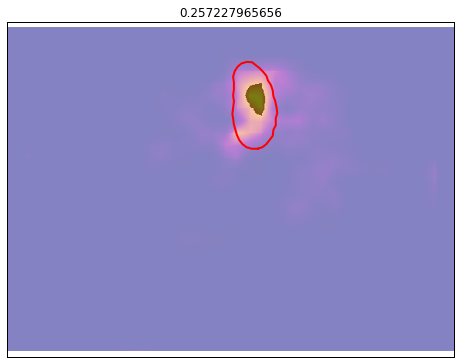

16 : 88 subject        4
img           54
hasmask    False
Name: 412, dtype: object


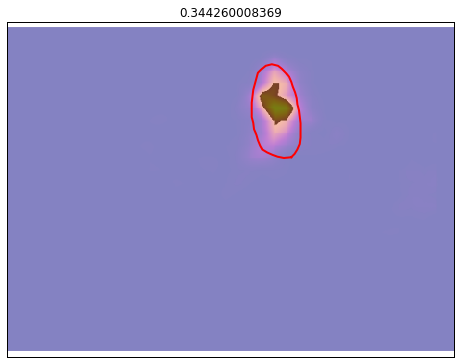

17 : 92 subject        4
img           68
hasmask    False
Name: 426, dtype: object


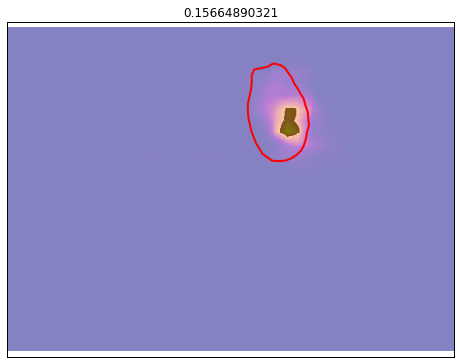

18 : 96 subject        4
img           89
hasmask    False
Name: 447, dtype: object


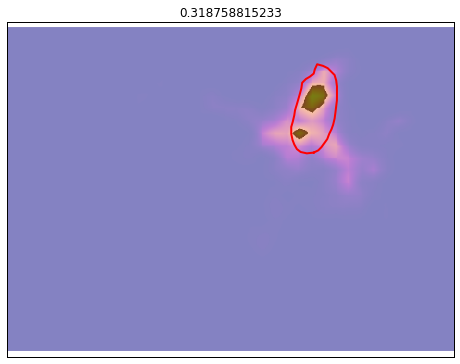

19 : 156 subject        7
img            6
hasmask    False
Name: 724, dtype: object


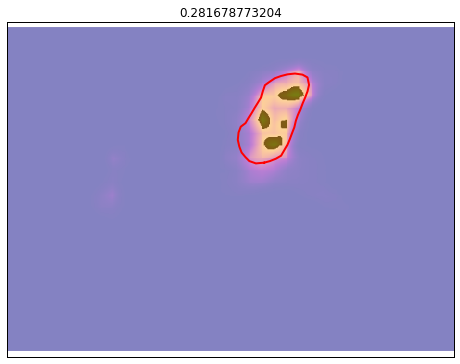

20 : 163 subject       7
img          41
hasmask    True
Name: 759, dtype: object


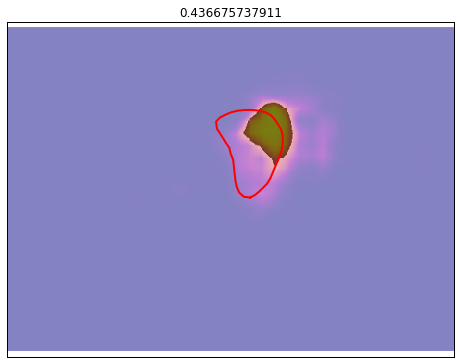

21 : 184 subject        8
img           14
hasmask    False
Name: 851, dtype: object


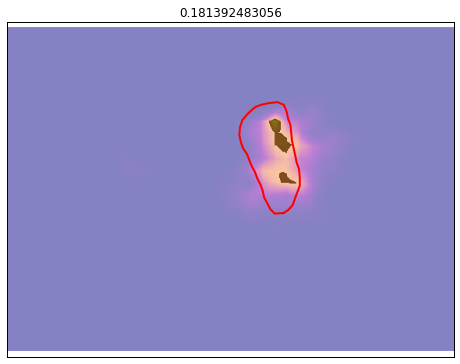

22 : 194 subject        8
img           81
hasmask    False
Name: 918, dtype: object


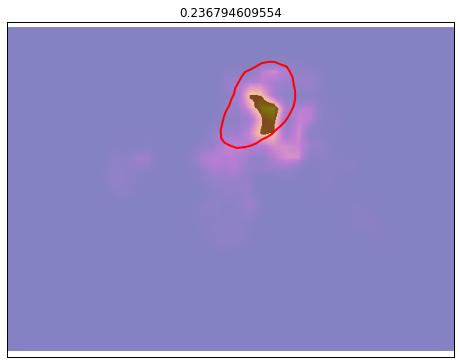

23 : 211 subject        9
img           40
hasmask    False
Name: 997, dtype: object


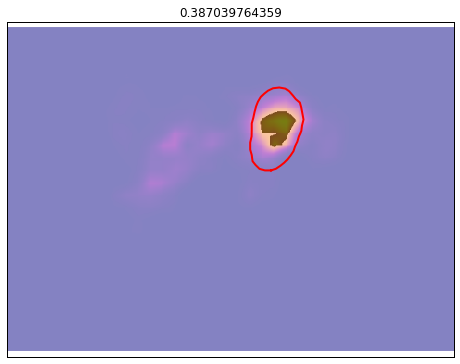

24 : 229 subject        9
img           90
hasmask    False
Name: 1047, dtype: object


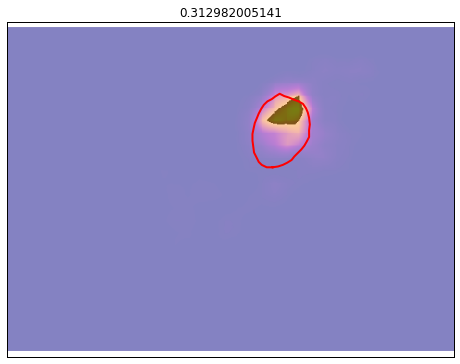

25 : 250 subject       10
img           59
hasmask    False
Name: 1136, dtype: object


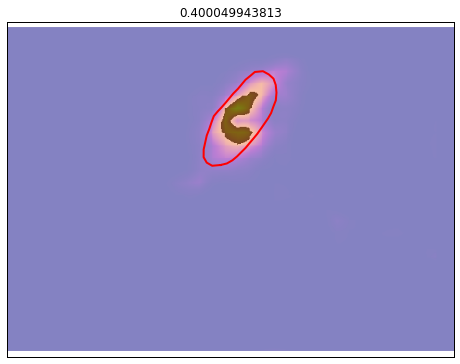

26 : 361 subject      15
img          36
hasmask    True
Name: 1713, dtype: object


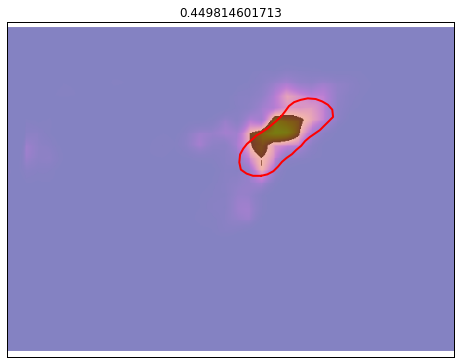

27 : 363 subject      15
img          45
hasmask    True
Name: 1722, dtype: object


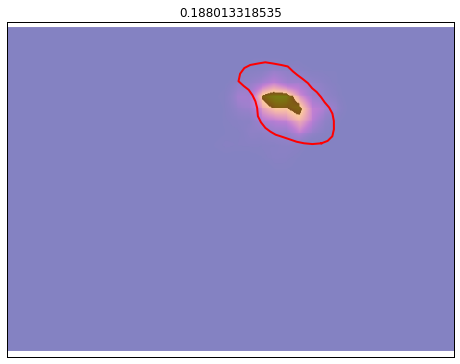

28 : 372 subject      15
img          77
hasmask    True
Name: 1754, dtype: object


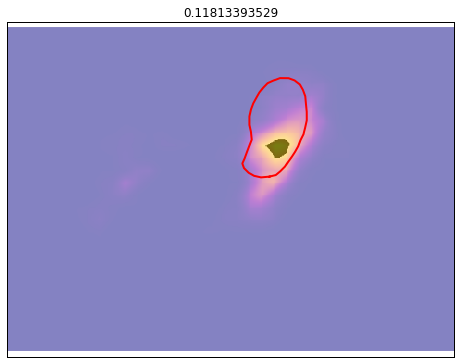

29 : 400 subject       17
img           11
hasmask    False
Name: 1928, dtype: object


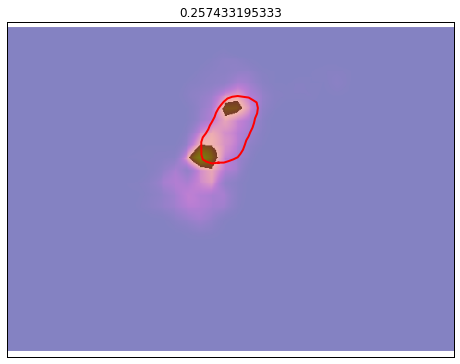

30 : 405 subject       17
img           40
hasmask    False
Name: 1957, dtype: object


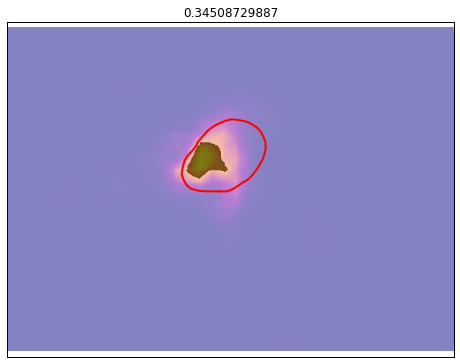

31 : 409 subject       17
img           48
hasmask    False
Name: 1965, dtype: object


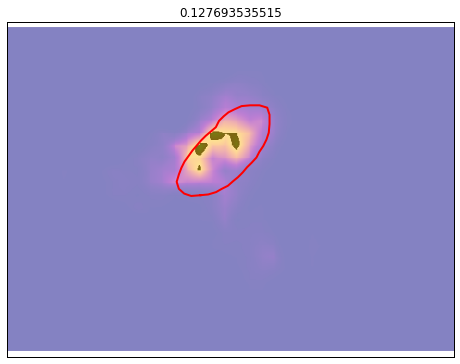

32 : 411 subject       17
img           60
hasmask    False
Name: 1977, dtype: object


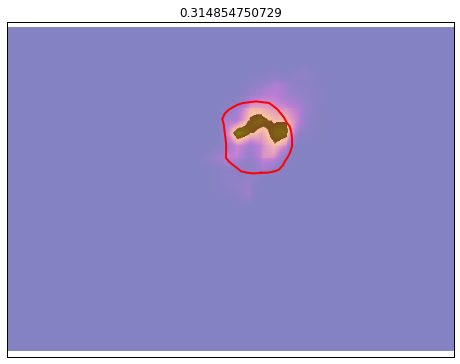

33 : 418 subject      18
img           2
hasmask    True
Name: 2038, dtype: object


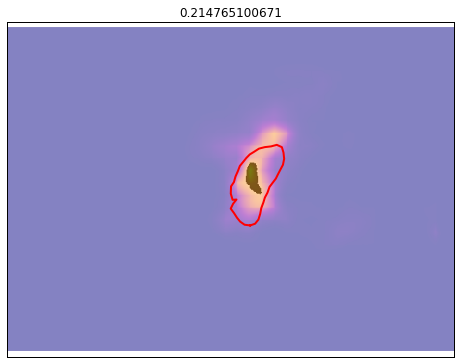

34 : 421 subject      18
img          18
hasmask    True
Name: 2054, dtype: object


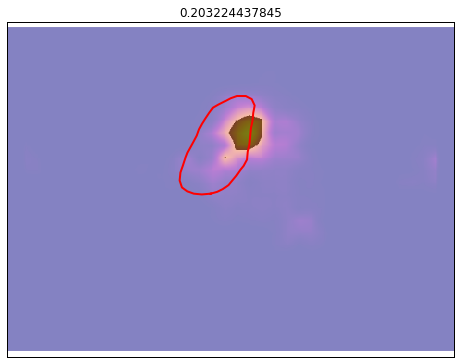

35 : 431 subject       18
img           70
hasmask    False
Name: 2106, dtype: object


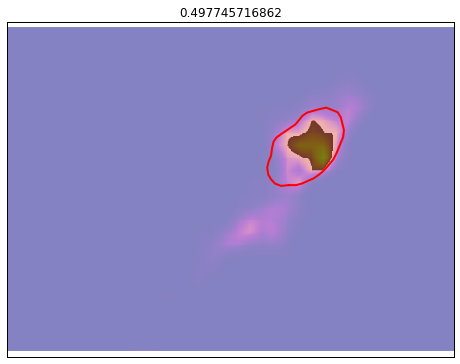

36 : 434 subject       18
img           80
hasmask    False
Name: 2116, dtype: object


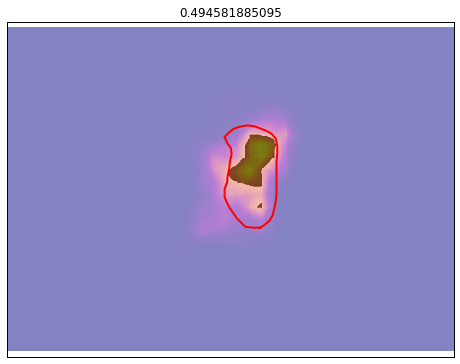

37 : 448 subject       19
img           35
hasmask    False
Name: 2191, dtype: object


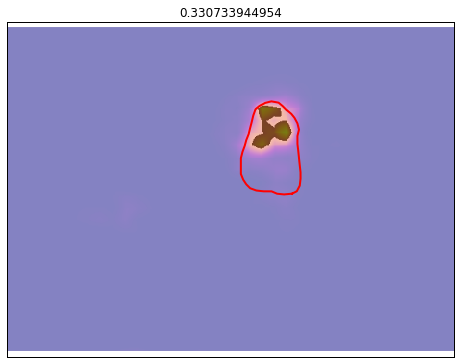

38 : 465 subject      20
img          28
hasmask    True
Name: 2304, dtype: object


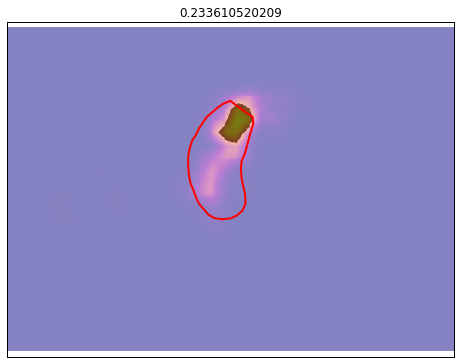

39 : 476 subject       20
img           86
hasmask    False
Name: 2362, dtype: object


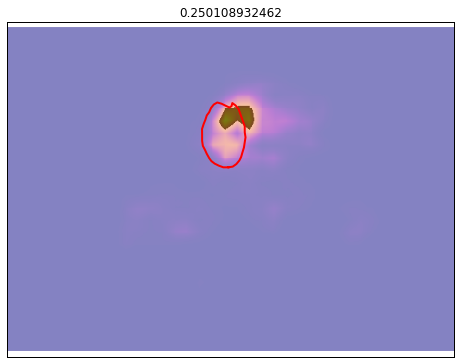

40 : 483 subject       21
img           31
hasmask    False
Name: 2427, dtype: object


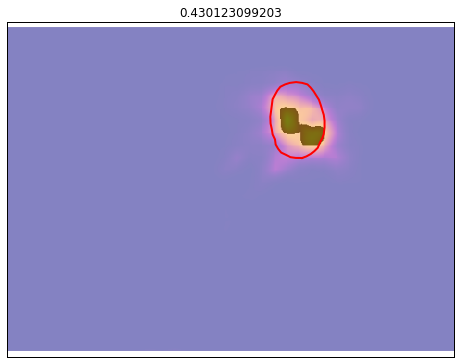

41 : 486 subject       21
img           45
hasmask    False
Name: 2441, dtype: object


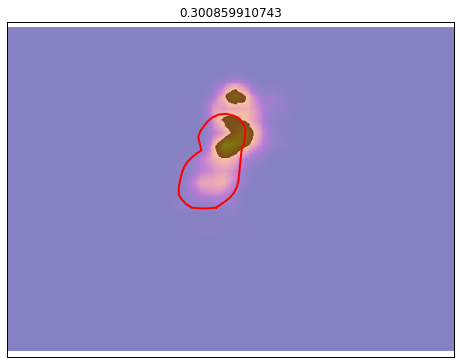

42 : 495 subject      21
img          94
hasmask    True
Name: 2490, dtype: object


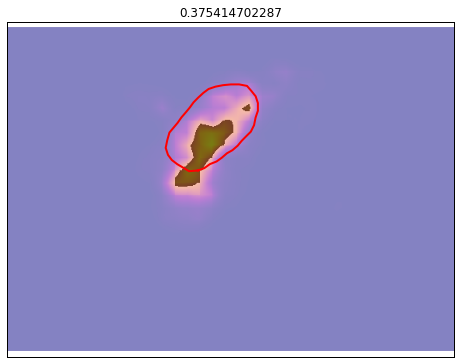

43 : 498 subject       21
img          102
hasmask    False
Name: 2498, dtype: object


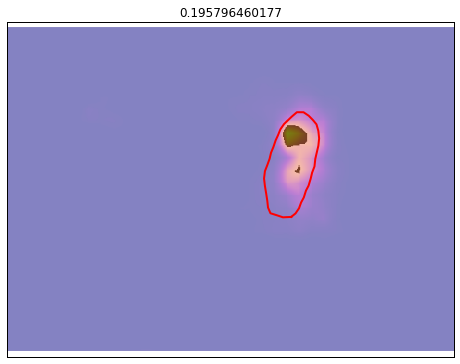

44 : 499 subject       21
img          104
hasmask    False
Name: 2500, dtype: object


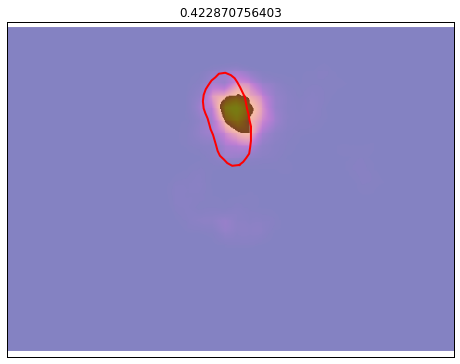

45 : 502 subject       21
img          120
hasmask    False
Name: 2516, dtype: object


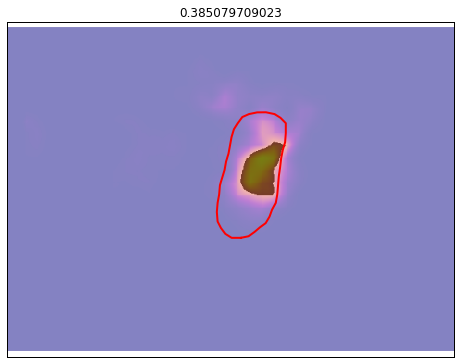

46 : 503 subject       22
img            6
hasmask    False
Name: 2522, dtype: object


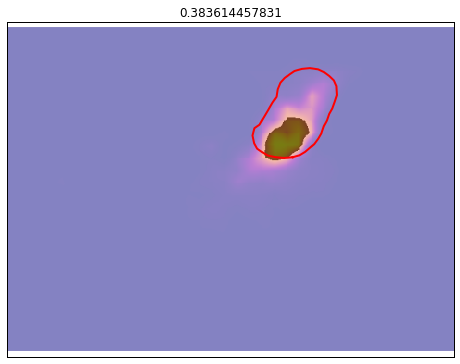

47 : 526 subject       22
img          117
hasmask    False
Name: 2633, dtype: object


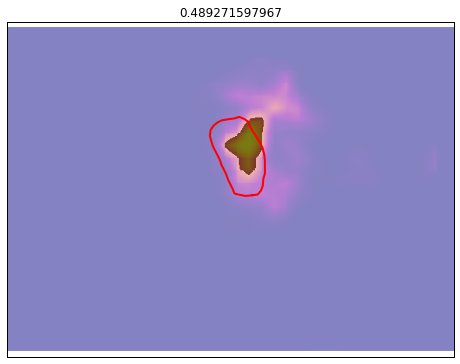

48 : 534 subject       23
img           62
hasmask    False
Name: 2698, dtype: object


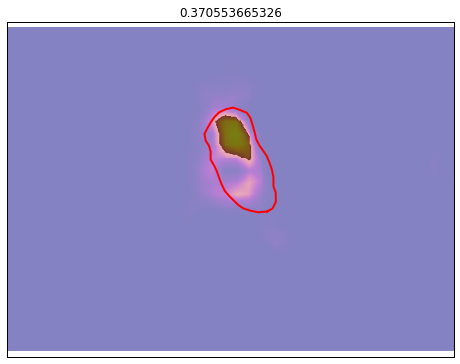

49 : 537 subject       23
img           66
hasmask    False
Name: 2702, dtype: object


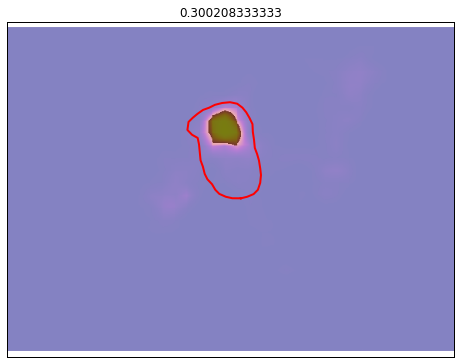

50 : 539 subject       23
img           68
hasmask    False
Name: 2704, dtype: object


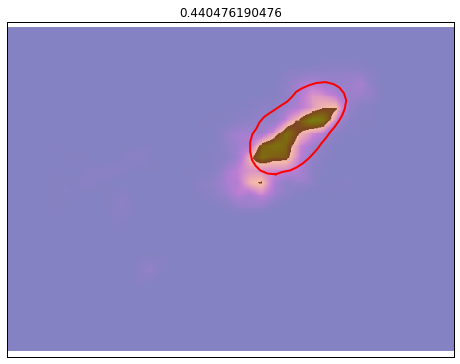

51 : 544 subject      23
img          86
hasmask    True
Name: 2722, dtype: object


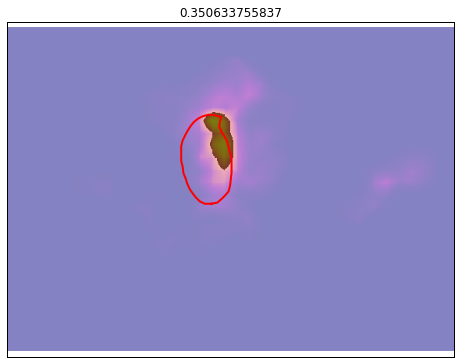

52 : 548 subject      23
img         118
hasmask    True
Name: 2754, dtype: object


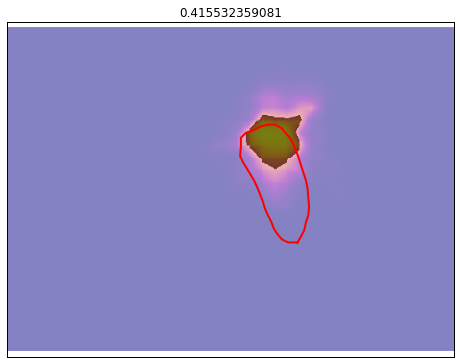

53 : 567 subject      24
img         113
hasmask    True
Name: 2869, dtype: object


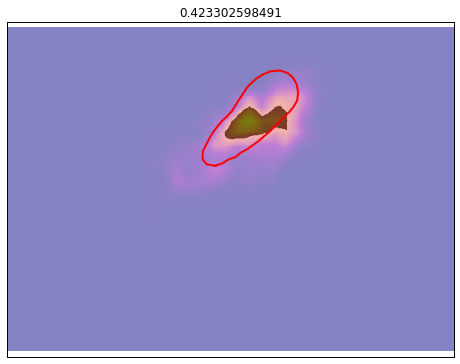

54 : 575 subject       25
img           23
hasmask    False
Name: 2899, dtype: object


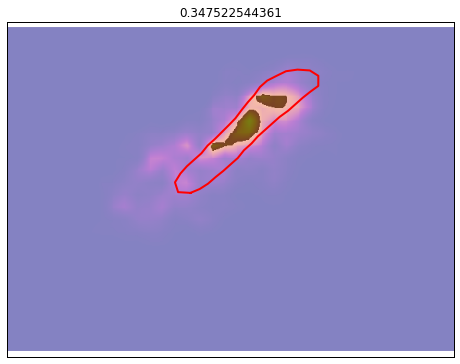

55 : 585 subject      26
img           1
hasmask    True
Name: 2997, dtype: object


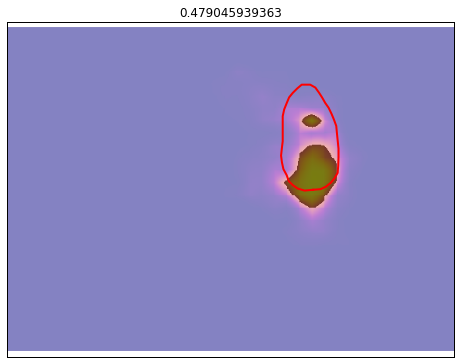

56 : 600 subject      26
img          99
hasmask    True
Name: 3095, dtype: object


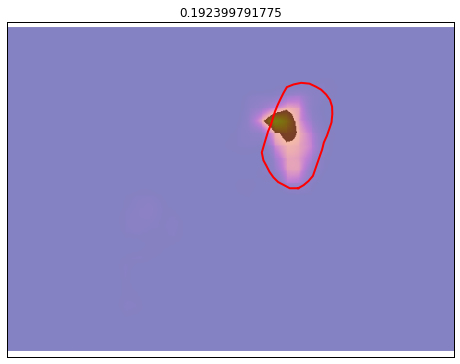

57 : 604 subject      26
img         109
hasmask    True
Name: 3105, dtype: object


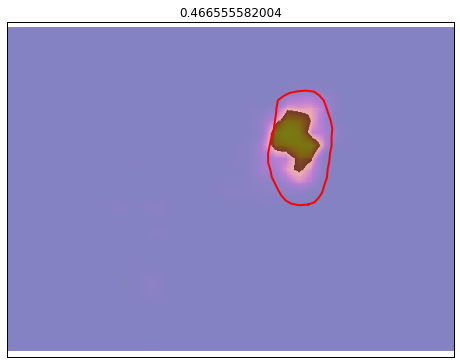

58 : 623 subject       27
img           67
hasmask    False
Name: 3183, dtype: object


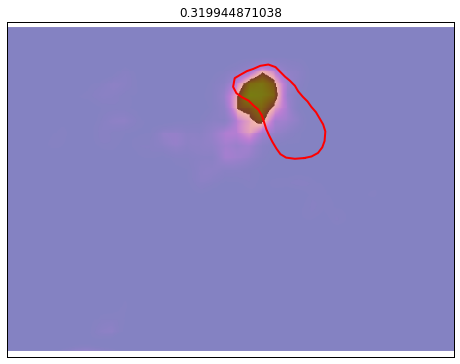

59 : 628 subject       27
img           90
hasmask    False
Name: 3206, dtype: object


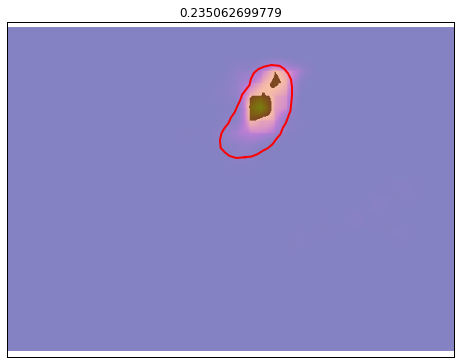

60 : 634 subject       27
img          115
hasmask    False
Name: 3231, dtype: object


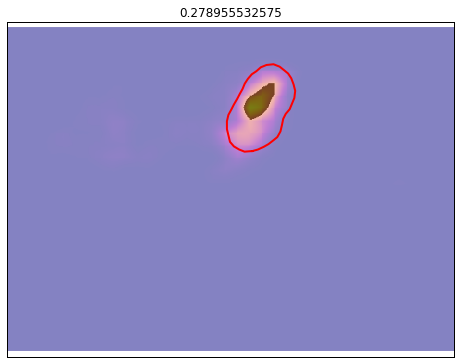

61 : 643 subject       28
img           52
hasmask    False
Name: 3288, dtype: object


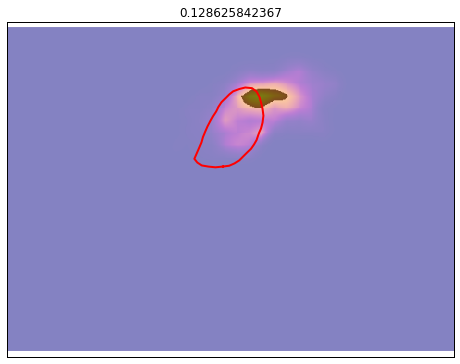

62 : 653 subject       28
img          100
hasmask    False
Name: 3336, dtype: object


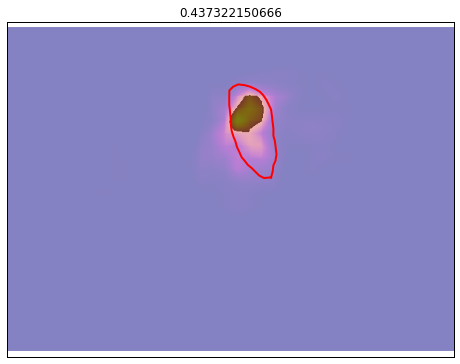

63 : 660 subject      29
img          19
hasmask    True
Name: 3375, dtype: object


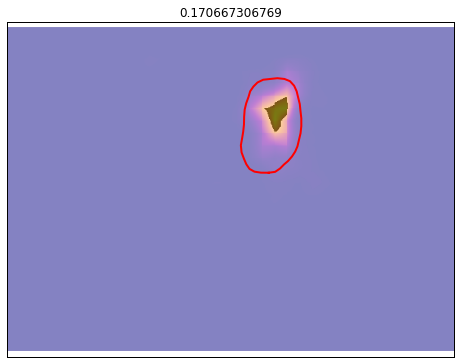

64 : 661 subject      29
img          49
hasmask    True
Name: 3405, dtype: object


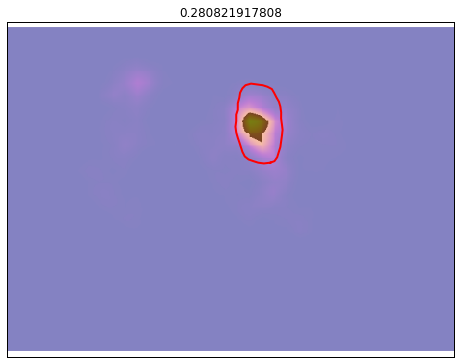

65 : 670 subject      29
img         117
hasmask    True
Name: 3473, dtype: object


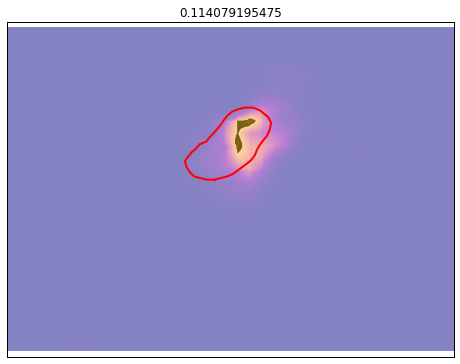

66 : 715 subject       32
img           29
hasmask    False
Name: 3745, dtype: object


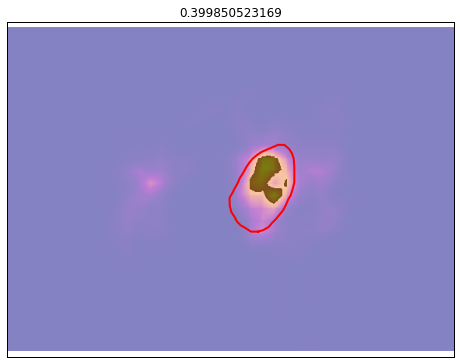

67 : 716 subject      32
img          30
hasmask    True
Name: 3746, dtype: object


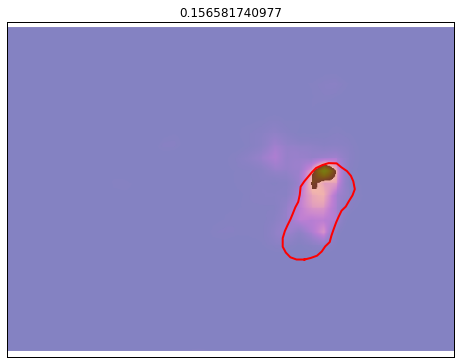

68 : 722 subject      32
img          60
hasmask    True
Name: 3776, dtype: object


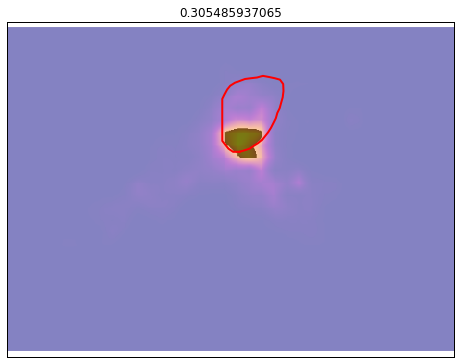

69 : 742 subject       33
img           19
hasmask    False
Name: 3855, dtype: object


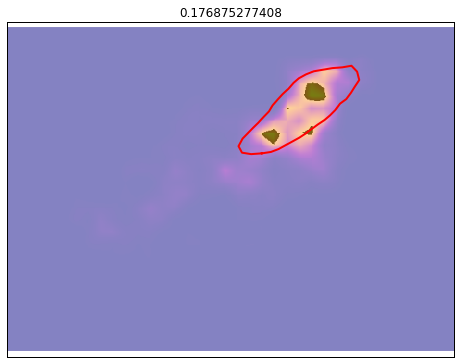

70 : 750 subject      33
img          45
hasmask    True
Name: 3881, dtype: object


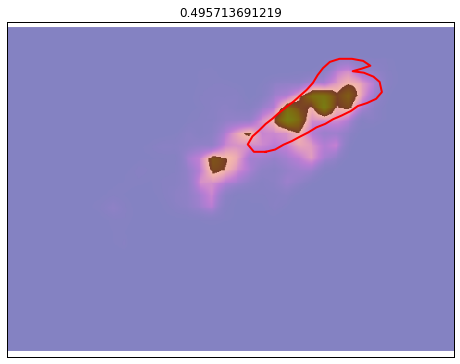

71 : 752 subject       33
img           47
hasmask    False
Name: 3883, dtype: object


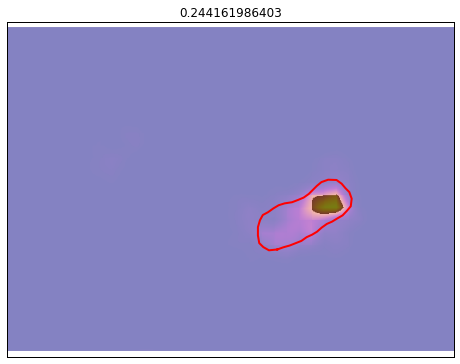

72 : 761 subject       33
img           86
hasmask    False
Name: 3922, dtype: object


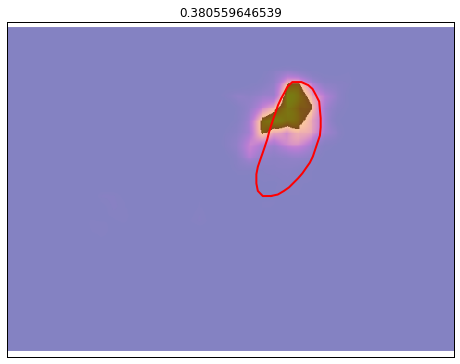

73 : 774 subject      34
img          41
hasmask    True
Name: 3997, dtype: object


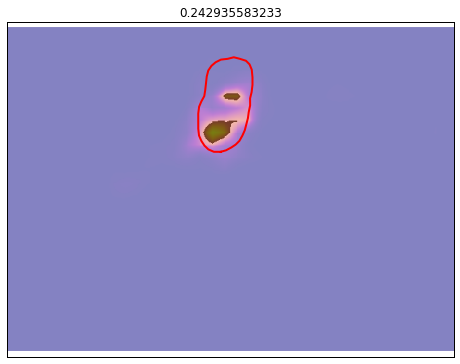

74 : 779 subject       34
img           68
hasmask    False
Name: 4024, dtype: object


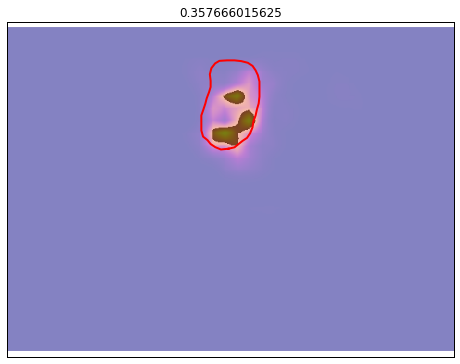

75 : 782 subject      34
img          83
hasmask    True
Name: 4039, dtype: object


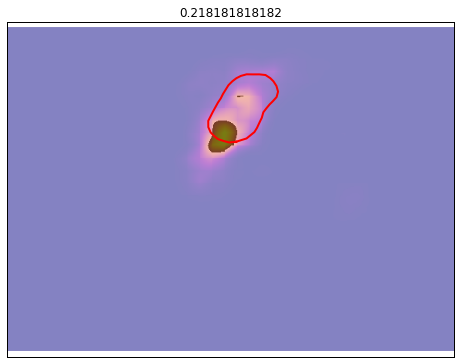

76 : 783 subject      34
img          85
hasmask    True
Name: 4041, dtype: object


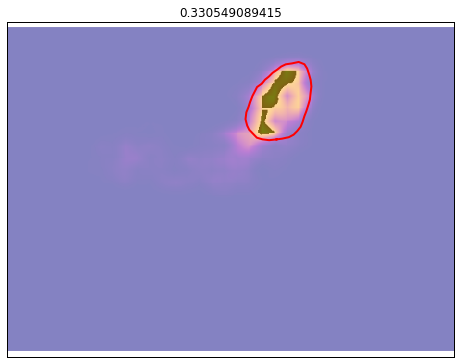

77 : 796 subject      35
img          18
hasmask    True
Name: 4093, dtype: object


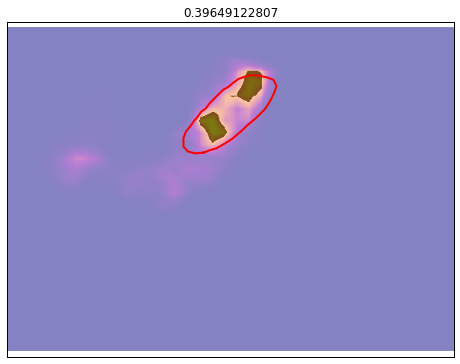

78 : 800 subject      35
img          33
hasmask    True
Name: 4108, dtype: object


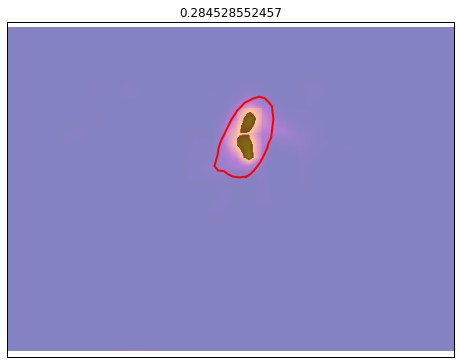

79 : 837 subject       36
img           74
hasmask    False
Name: 4269, dtype: object


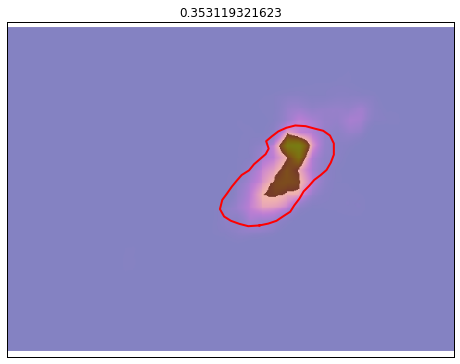

80 : 844 subject       36
img          107
hasmask    False
Name: 4302, dtype: object


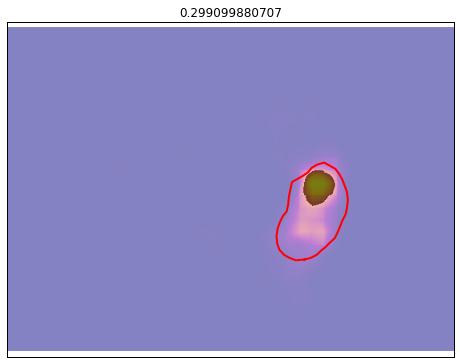

81 : 856 subject      37
img          56
hasmask    True
Name: 4371, dtype: object


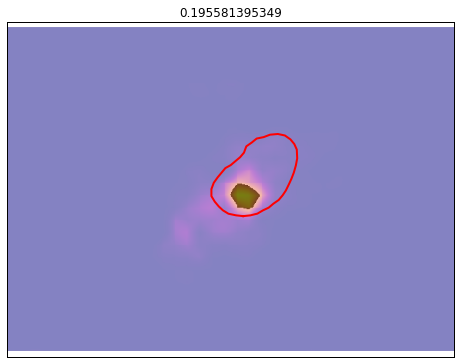

82 : 859 subject      37
img          64
hasmask    True
Name: 4379, dtype: object


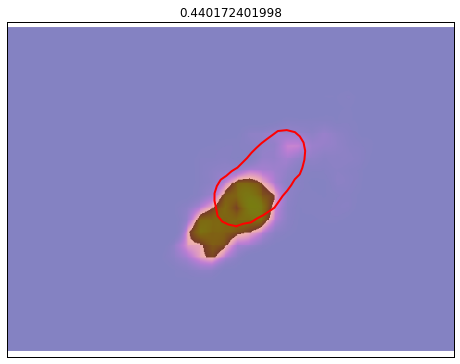

83 : 870 subject      37
img         113
hasmask    True
Name: 4428, dtype: object


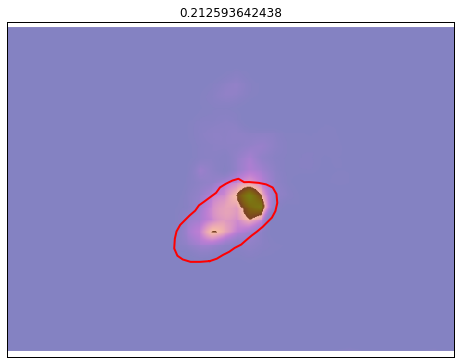

84 : 871 subject      37
img         114
hasmask    True
Name: 4429, dtype: object


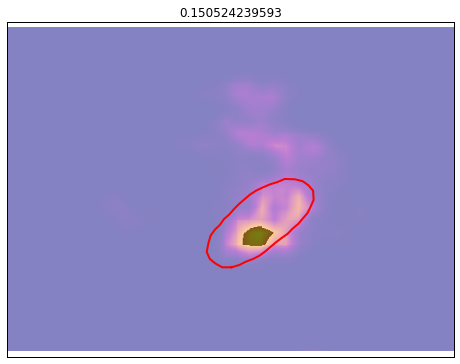

85 : 872 subject      37
img         117
hasmask    True
Name: 4432, dtype: object


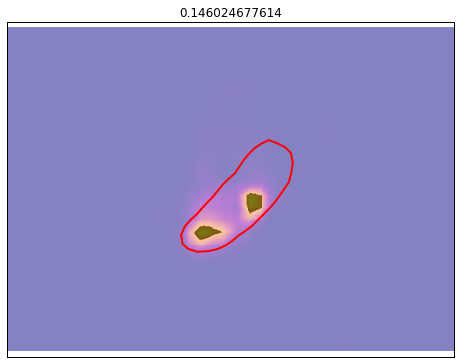

86 : 875 subject      38
img           6
hasmask    True
Name: 4441, dtype: object


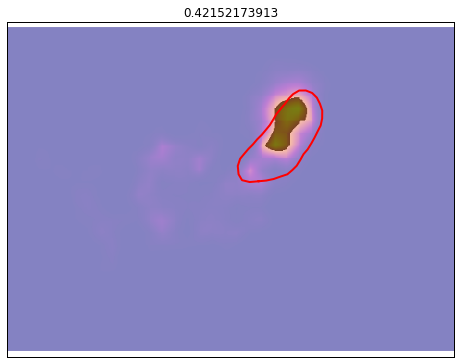

87 : 877 subject      38
img           8
hasmask    True
Name: 4443, dtype: object


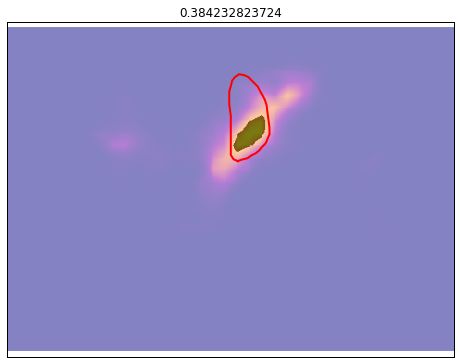

88 : 880 subject       38
img           17
hasmask    False
Name: 4452, dtype: object


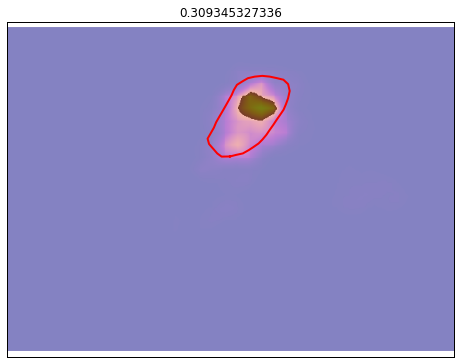

89 : 882 subject      38
img          25
hasmask    True
Name: 4460, dtype: object


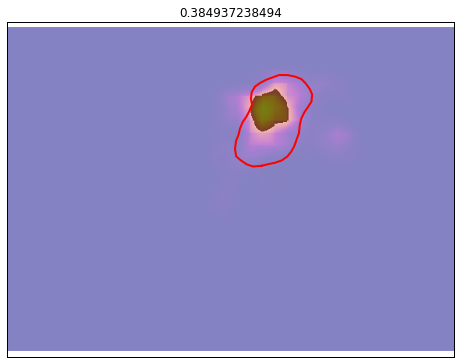

90 : 897 subject       38
img          116
hasmask    False
Name: 4551, dtype: object


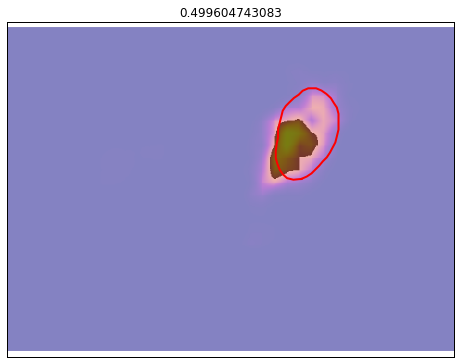

91 : 913 subject       39
img           72
hasmask    False
Name: 4627, dtype: object


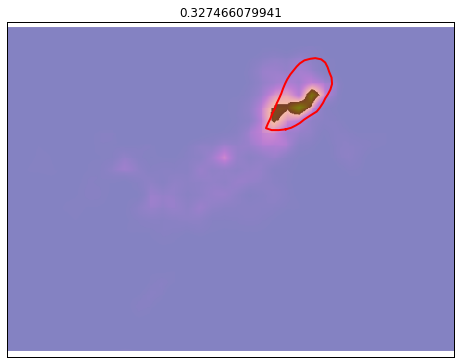

92 : 933 subject       40
img           56
hasmask    False
Name: 4731, dtype: object


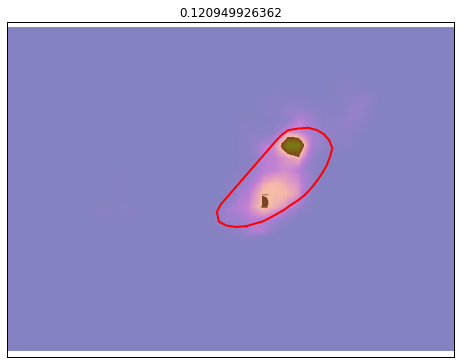

93 : 934 subject       40
img           60
hasmask    False
Name: 4735, dtype: object


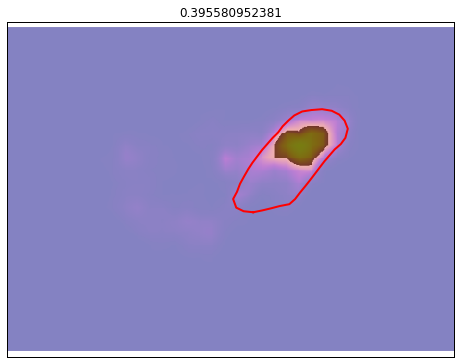

94 : 951 subject      41
img          43
hasmask    True
Name: 4838, dtype: object


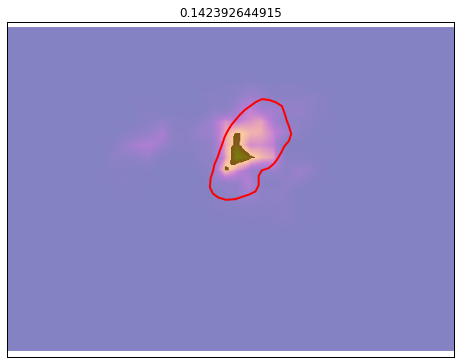

95 : 959 subject      41
img          61
hasmask    True
Name: 4856, dtype: object


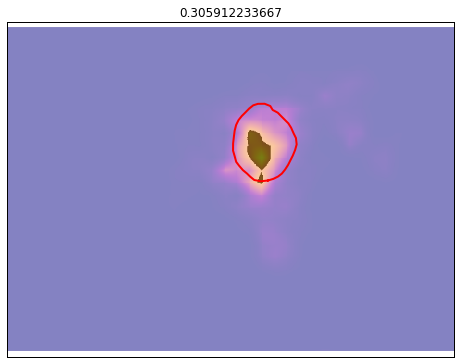

96 : 980 subject      42
img          27
hasmask    True
Name: 4942, dtype: object


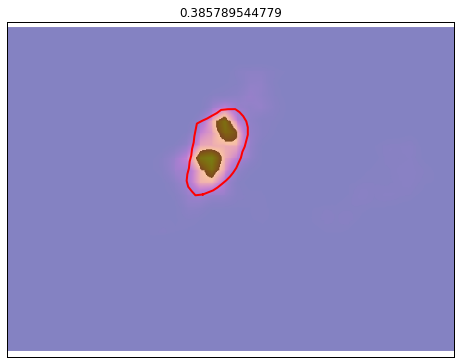

97 : 1024 subject       44
img            7
hasmask    False
Name: 5162, dtype: object


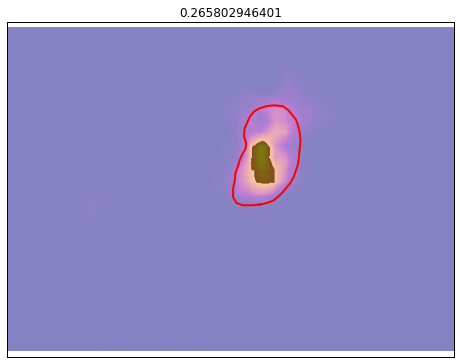

98 : 1072 subject       45
img           67
hasmask    False
Name: 5341, dtype: object


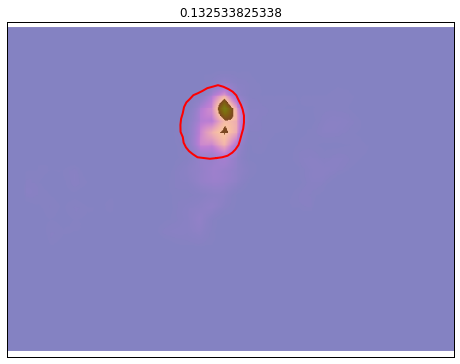

99 : 1073 subject       45
img           74
hasmask    False
Name: 5348, dtype: object


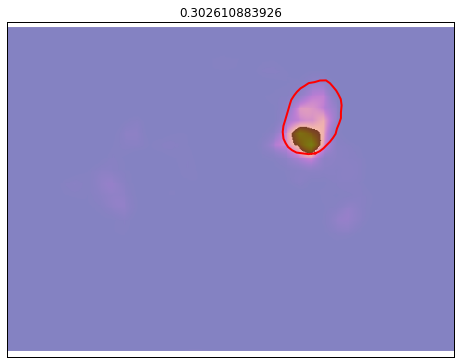

100 : 1074 subject       45
img           88
hasmask    False
Name: 5362, dtype: object


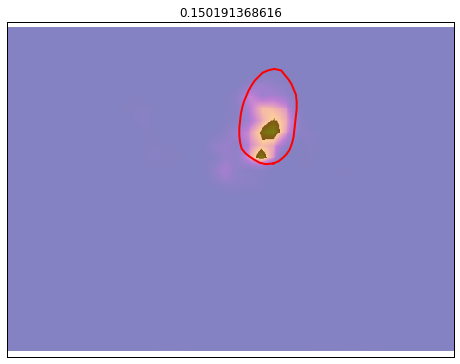

101 : 1078 subject       45
img          111
hasmask    False
Name: 5385, dtype: object


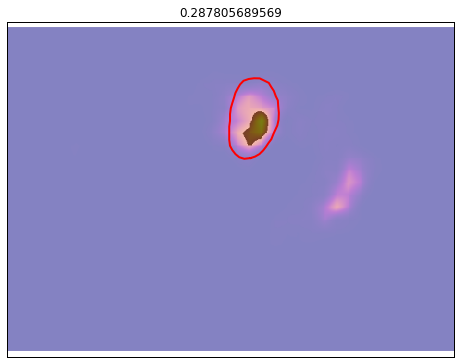

102 : 1081 subject       45
img          117
hasmask    False
Name: 5391, dtype: object


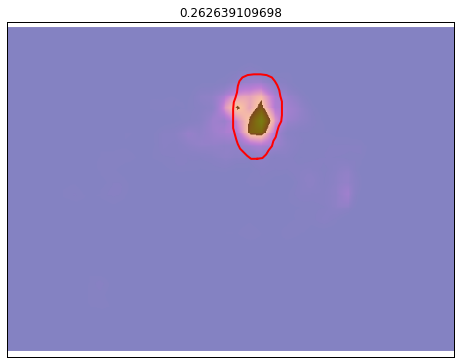

103 : 1094 subject       46
img           66
hasmask    False
Name: 5460, dtype: object


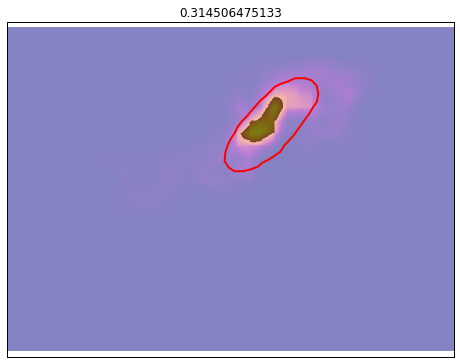

In [69]:
subset = tr[tr['validate']].iloc[indices]
batch = uns.batch(subset)

for i,j in enumerate(indices):
    print(i,':',j, subset.iloc[i][['subject','img','hasmask']])
    ax = plot_pred_mask(j)
    #batch[i].mask.plot_contour(ax=ax, lw=2.0, c='r')
    plt.show()
    

What do the masks in the bottleneck files look like?

In [171]:
indices = [6,7]

1_55.btl


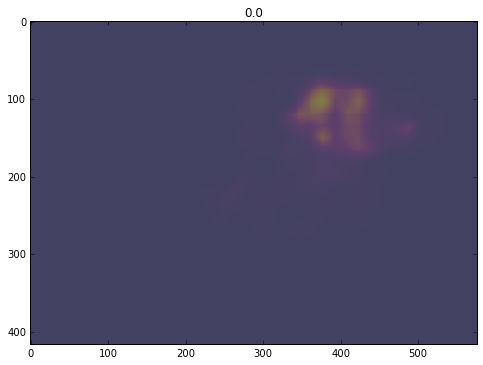

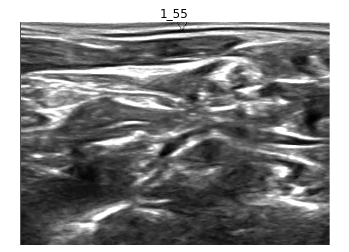

In [172]:
batch = uns.batch(tr[tr['validate']].iloc[indices])

imgpair = batch.pop(0)
print(imgpair.bottlefile)
i = indices.pop(0)
plot_pred_mask(i)
imgpair.plot()
record = np.fromfile('../bottleneck_files/' + imgpair.bottlefile, dtype=np.float32)

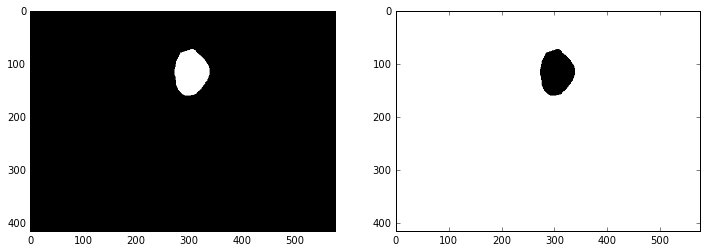

In [135]:
fc6dim = 13, 18, 4096
pooldim = 26, 36, 512
maskdim = 416, 576, 2 

Nfc6 = np.prod(fc6dim)
Npool = np.prod(pooldim)
Nmask = np.prod(maskdim)
#print(record.shape, Nfc6 + Npool + Nmask)

fc6 = record[:Nfc6].reshape(fc6dim)
pool = record[Nfc6:Nfc6+Npool].reshape(pooldim)
mask = np.reshape(record[Nfc6+Npool:], maskdim)

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].imshow(mask[:,:,0], cmap=plt.cm.gray)
ax[1].imshow(mask[:,:,1], cmap=plt.cm.gray)

0


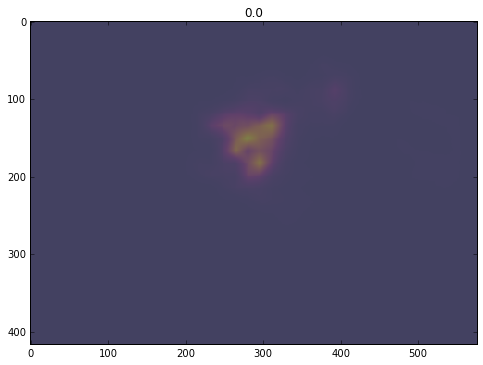

In [136]:
j = np.argmax(np.sum(np.logical_and(mask[:,:,0]>0, data[:,idxmask,:,:]), axis=(2,1)))

plot_pred_mask(j)
print(j)